In [ ]:
#TensorFlow یک کتابخانه متن باز برای یادگیری ماشین و یادگیری عمیق است که توسط گوگل توسعه داده شده است. این کتابخانه به شما این امکان را می‌دهد که مدل‌های یادگیری عمیق را بسازید و آموزش دهید.
!pip install tensorflow==2.15.0
!pip install tensorflow-quantum==0.7.3

import importlib, pkg_resources
importlib.reload(pkg_resources)

<ipython-input-1-521053292e25>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py'>

In [ ]:
# وارد کردن کتابخانه TensorFlow
import tensorflow as tf

# وارد کردن کتابخانه TensorFlow Quantum برای کار با محاسبات کوانتومی
import tensorflow_quantum as tfq

# وارد کردن مجموعه داده Fashion MNIST از Keras
from tensorflow.keras.datasets import fashion_mnist

# وارد کردن ابزارهای منظم‌سازی از Keras
from tensorflow.keras import regularizers

# وارد کردن کتابخانه Cirq برای کار با مدارهای کوانتومی
import cirq

# وارد کردن SymPy برای کار با ریاضیات نمادین
import sympy

# وارد کردن NumPy برای پردازش داده‌های عددی
import numpy as np

# وارد کردن متریک‌های ارزیابی از scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# تنظیم نمایش نمودارها در Jupyter Notebook
%matplotlib inline

# وارد کردن کتابخانه Matplotlib برای ترسیم نمودارها
import matplotlib.pyplot as plt

# وارد کردن ابزار SVGCircuit از Cirq برای نمایش مدارهای کوانتومی به صورت SVG
from cirq.contrib.svg import SVGCircuit

In [ ]:
# بارگذاری مجموعه داده Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# انتخاب فقط کلاس T-shirt (0) و Trouser (1)
classes_to_keep = [0, 1]  # کلاس‌هایی که می‌خواهیم نگه‌داریم
train_filter = np.isin(train_labels, classes_to_keep)  # فیلتر کردن داده‌های آموزشی
train_images = train_images[train_filter]  # اعمال فیلتر به تصاویر آموزشی
train_labels = train_labels[train_filter]  # اعمال فیلتر به برچسب‌های آموزشی

test_filter = np.isin(test_labels, classes_to_keep)  # فیلتر کردن داده‌های آزمایشی
test_images = test_images[test_filter]  # اعمال فیلتر به تصاویر آزمایشی
test_labels = test_labels[test_filter]  # اعمال فیلتر به برچسب‌های آزمایشی

# تغییر مقیاس تصاویر به بازه [0, 1]
train_images = train_images / 255.0  # نرمال‌سازی تصاویر آموزشی
test_images = test_images / 255.0  # نرمال‌سازی تصاویر آزمایشی

# اضافه کردن ابعاد کانال برای سازگاری با پایپ‌لاین QCNN (خاکستری: یک کانال)
train_images = train_images[..., np.newaxis]  # اضافه کردن بعد جدید به تصاویر آموزشی
test_images = test_images[..., np.newaxis]  # اضافه کردن بعد جدید به تصاویر آزمایشی

# چاپ شکل داده‌های آموزشی و آزمایشی
print("Training Data Shape:", train_images.shape)  # نمایش شکل داده‌های آموزشی
print("Testing Data Shape:", test_images.shape)  # نمایش شکل داده‌های آزمایشی

Training Data Shape: (12000, 28, 28, 1)
Testing Data Shape: (2000, 28, 28, 1)


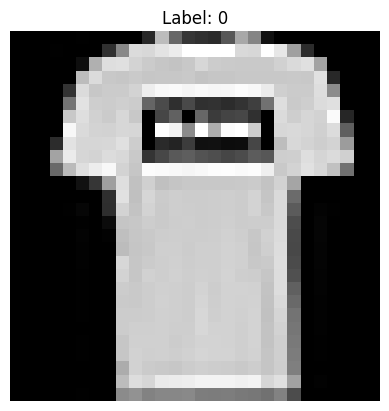

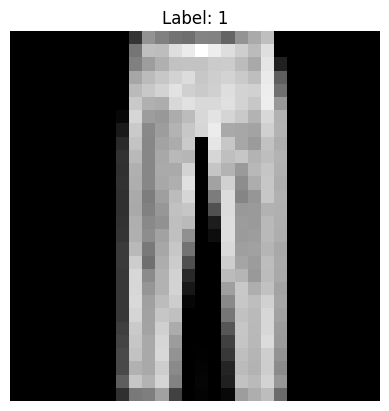

In [ ]:
# پیدا کردن اولین ایندکس برای کلاس 0 (T-shirt)
class_0_index = np.where(train_labels == 0)[0][0]

# پیدا کردن اولین ایندکس برای کلاس 1 (Trouser)
class_1_index = np.where(train_labels == 1)[0][0]

# انتخاب ایندکس‌های کلاس‌های مورد نظر
selected = [class_0_index, class_1_index]

# چاپ جفت‌های ورودی و خروجی
for index in selected:
    input_image = train_images[index]  # گرفتن تصویر ورودی برای ایندکس انتخاب شده
    output_label = train_labels[index]  # گرفتن برچسب خروجی برای ایندکس انتخاب شده

    # نمایش تصویر
    plt.imshow(input_image, cmap='gray')  # نمایش تصویر به صورت خاکستری
    plt.title(f'Label: {output_label}')  # عنوان تصویر شامل برچسب
    plt.axis('off')  # پنهان کردن محورهای نمودار
    plt.show()  # نمایش تصویر

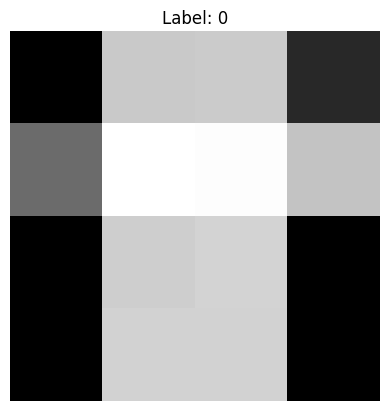

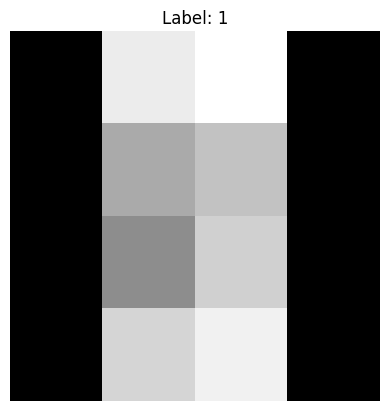

In [ ]:
# 28x28 برای کدگذاری به کیوبیت‌ها بسیار بزرگ است و قادر به شبیه‌سازی مدار نخواهد بود
# تغییر اندازه تصاویر به 4x4
train_images = tf.image.resize(train_images, (4, 4)).numpy()  # تغییر اندازه تصاویر آموزشی
test_images = tf.image.resize(test_images, (4, 4)).numpy()    # تغییر اندازه تصاویر آزمایشی

# چاپ جفت‌های ورودی و خروجی
for index in selected:
    input_image = train_images[index]  # گرفتن تصویر ورودی برای ایندکس انتخاب شده
    output_label = train_labels[index]  # گرفتن برچسب خروجی برای ایندکس انتخاب شده

    # نمایش تصویر
    plt.imshow(input_image, cmap='gray')  # نمایش تصویر به صورت خاکستری
    plt.title(f'Label: {output_label}')  # عنوان تصویر شامل برچسب
    plt.axis('off')  # پنهان کردن محورهای نمودار
    plt.show()  # نمایش تصویر

Noisy Training Data Shape: (12000, 4, 4, 1)
Noisy Testing Data Shape: (2000, 4, 4, 1)


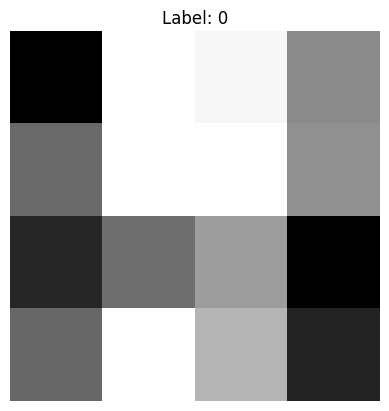

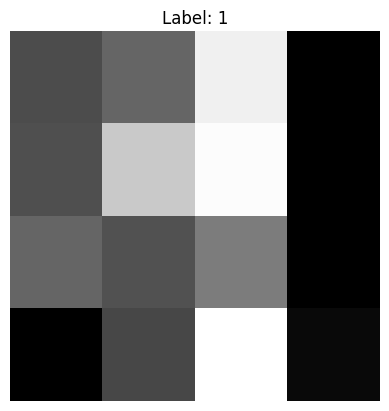

In [ ]:
# تابعی برای افزودن نویز گاوسی به تصاویر
def add_gaussian_noise(images, mean=0.0, severity=1):
    # سطوح شدت مختلف برای نویز
    severity_levels = [0.08, 0.12, 0.18, 0.26, 0.38]
    stddev = severity_levels[severity - 1]  # گرفتن انحراف معیار بر اساس شدت (1 تا 5)

    # تولید نویز گاوسی
    noise = np.random.normal(mean, stddev, images.shape)

    # افزودن نویز به تصاویر
    noisy_images = images + noise

    # اطمینان از اینکه مقادیر پیکسل‌ها در بازه نرمال شده قرار دارند
    noisy_images = np.clip(noisy_images, 0.0, 1.0)

    return noisy_images  # بازگشت تصاویر با نویز

# افزودن نویز به داده‌های آموزشی و آزمایشی
train_data_noisy = add_gaussian_noise(train_images, severity=5)  # حداکثر شدت نویز برای داده‌های آموزشی
test_data_noisy = add_gaussian_noise(test_images, severity=5)    # حداکثر شدت نویز برای داده‌های آزمایشی

# چاپ شکل داده‌های آموزشی و آزمایشی با نویز
print("Noisy Training Data Shape:", train_data_noisy.shape)  # نمایش شکل داده‌های آموزشی با نویز
print("Noisy Testing Data Shape:", test_data_noisy.shape)    # نمایش شکل داده‌های آزمایشی با نویز

# چاپ جفت‌های ورودی و خروجی
for index in selected:
    input_image = train_data_noisy[index]  # گرفتن تصویر ورودی با نویز برای ایندکس انتخاب شده
    output_label = train_labels[index]      # گرفتن برچسب خروجی برای ایندکس انتخاب شده

    # نمایش تصویر
    plt.imshow(input_image, cmap='gray')  # نمایش تصویر به صورت خاکستری
    plt.title(f'Label: {output_label}')  # عنوان تصویر شامل برچسب
    plt.axis('off')  # پنهان کردن محورهای نمودار
    plt.show()  # نمایش تصویر

In [ ]:
# کدگذاری هر پیکسل به یک کیوبیت، فعال‌سازی حالت بستگی به آستانه دارد
THRESHOLD = 0.5  # تعیین آستانه برای کدگذاری باینری

# ایجاد کدگذاری باینری برای داده‌های پاک
x_train_bin_clean = np.array(train_images > THRESHOLD, dtype=np.float32)  # کدگذاری تصاویر آموزشی پاک
x_test_bin_clean = np.array(test_images > THRESHOLD, dtype=np.float32)    # کدگذاری تصاویر آزمایشی پاک

# ایجاد کدگذاری باینری برای داده‌های نویزی
x_train_bin_noisy = np.array(train_data_noisy > THRESHOLD, dtype=np.float32)  # کدگذاری تصاویر آموزشی با نویز
x_test_bin_noisy = np.array(test_data_noisy > THRESHOLD, dtype=np.float32)    # کدگذاری تصاویر آزمایشی با نویز

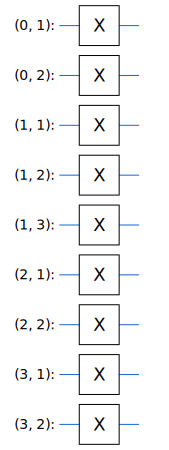

In [ ]:
# تبدیل تصاویر کلاسیک به داده‌های کوانتومی
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)  # مسطح کردن تصویر به یک آرایه یک بعدی
    qubits = cirq.GridQubit.rect(4, 4)  # ایجاد کیوبیت‌ها در یک شبکه 4x4
    circuit = cirq.Circuit()  # ایجاد مدار کوانتومی جدید
    for i, value in enumerate(values):
        if value:  # اگر مقدار پیکسل 1 باشد
            circuit.append(cirq.X(qubits[i]))  # اعمال گیت X (NOT) بر روی کیوبیت مربوطه
    return circuit  # بازگشت مدار کوانتومی

# تبدیل تصاویر آموزشی و آزمایشی پاک به مدار کوانتومی
x_train_circ_clean = [convert_to_circuit(x) for x in x_train_bin_clean]  # تبدیل داده‌های آموزشی پاک
x_test_circ_clean = [convert_to_circuit(x) for x in x_test_bin_clean]      # تبدیل داده‌های آزمایشی پاک

# تبدیل تصاویر آموزشی و آزمایشی نویزی به مدار کوانتومی
x_train_circ_noisy = [convert_to_circuit(x) for x in x_train_bin_noisy]  # تبدیل داده‌های آموزشی نویزی
x_test_circ_noisy = [convert_to_circuit(x) for x in x_test_bin_noisy]    # تبدیل داده‌های آزمایشی نویزی

# نمایش مدار کوانتومی برای اولین تصویر آموزشی پاک
SVGCircuit(x_train_circ_clean[0])  # نمایش مدار کوانتومی برای تصویر اول

In [ ]:
# تبدیل مدارهای Cirq به تنسورها
x_train_tfcirc_clean = tfq.convert_to_tensor(x_train_circ_clean)  # تبدیل مدارهای آموزشی پاک به تنسور
x_test_tfcirc_clean = tfq.convert_to_tensor(x_test_circ_clean)      # تبدیل مدارهای آزمایشی پاک به تنسور

x_train_tfcirc_noisy = tfq.convert_to_tensor(x_train_circ_noisy)    # تبدیل مدارهای آموزشی نویزی به تنسور
x_test_tfcirc_noisy = tfq.convert_to_tensor(x_test_circ_noisy)      # تبدیل مدارهای آزمایشی نویزی به تنسور

In [ ]:
# توابعی برای ایجاد لایه‌های مدار کوانتومی
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits  # کیوبیت‌های داده
        self.readout = readout            # کیوبیت خواندن (readout)

    def add_layer(self, circuit, gate, prefix):
        # افزودن یک لایه به مدار
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))  # ایجاد نماد برای پارامتر گیت
            circuit.append(gate(qubit, self.readout)**symbol)  # افزودن گیت به مدار با نماد

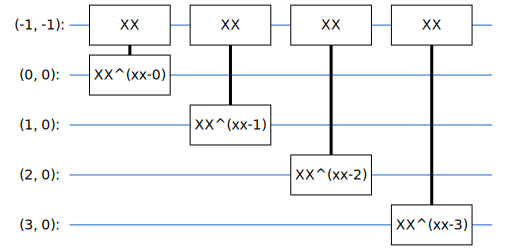

In [ ]:
# نمونه‌ای از نحوه ایجاد مدار
demo_builder = CircuitLayerBuilder(data_qubits=cirq.GridQubit.rect(4, 1),  # ایجاد کیوبیت‌های داده در یک شبکه 4x1
                                   readout=cirq.GridQubit(-1, -1))       # ایجاد کیوبیت خواندن در مختصات (-1, -1)

circuit = cirq.Circuit()  # ایجاد مدار کوانتومی جدید
demo_builder.add_layer(circuit, gate=cirq.XX, prefix='xx')  # افزودن یک لایه با گیت XX به مدار
SVGCircuit(circuit)  # نمایش مدار کوانتومی

In [ ]:
# ایجاد مدار مدل QCNN و عملیات خواندن
def create_quantum_model():
    data_qubits = cirq.GridQubit.rect(4, 4)  # ایجاد کیوبیت‌های داده در یک شبکه 4x4
    readout = cirq.GridQubit(-1, -1)         # ایجاد یک کیوبیت خواندن در مختصات [-1,-1]
    circuit = cirq.Circuit()                  # ایجاد مدار کوانتومی جدید

    # آماده‌سازی کیوبیت خواندن
    circuit.append(cirq.X(readout))           # اعمال گیت X بر روی کیوبیت خواندن
    circuit.append(cirq.H(readout))           # اعمال گیت هادامارد بر روی کیوبیت خواندن

    builder = CircuitLayerBuilder(
        data_qubits=data_qubits,              # ارسال کیوبیت‌های داده به سازنده
        readout=readout                        # ارسال کیوبیت خواندن به سازنده
    )

    # لایه اول، درهم‌تنیدگی
    builder.add_layer(circuit, cirq.XX, "xx1")  # افزودن لایه با گیت XX
    builder.add_layer(circuit, cirq.ZZ, "zz1")  # افزودن لایه با گیت ZZ

    # لایه دوم، گیت‌های کوانتومی پارامتری
    for q in data_qubits:
        theta = sympy.Symbol(f"theta_{q.row}_{q.col}", regularizer=regularizers.l2(0.01))  # پارامتر برای چرخش حول محور y
        phi = sympy.Symbol(f"phi_{q.row}_{q.col}", regularizer=regularizers.l2(0.01))      # پارامتر برای چرخش حول محور z
        circuit.append(cirq.ry(theta)(q))  # افزودن گیت چرخش حول محور y با پارامتر theta
        circuit.append(cirq.rz(phi)(q))    # افزودن گیت چرخش حول محور z با پارامتر phi

    # در نهایت، آماده‌سازی کیوبیت خواندن
    circuit.append(cirq.H(readout))  # اعمال گیت هادامارد مجدداً بر روی کیوبیت خواندن

    return circuit, cirq.Z(readout)  # بازگشت مدار و عملیات خواندن

# اجرای تابع
model_circuit, model_readout = create_quantum_model()  # ایجاد مدار و عملیات خواندن

In [ ]:
# ساخت مدل پاک
clean_model = tf.keras.Sequential([
    # ورودی داده‌ها که به عنوان یک رشته tf.string رمزگذاری شده است
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # لایه PQC انتظار مقدار گیت خواندن را باز می‌گرداند، در بازه [-1, 1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
# کامپایل مدل پاک و چاپ خلاصه آن

clean_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # تعیین تابع ضرر به عنوان تقاطع باینری
    optimizer=tf.keras.optimizers.Adam(),                        # استفاده از بهینه‌ساز آدام
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)]    # تعیین معیار دقت باینری با آستانه 0.0
)

print(clean_model.summary())  # چاپ خلاصه مدل شامل تعداد لایه‌ها و پارامترها

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 64        
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# آموزش مدل پاک با داده‌های پاک
history_clean = clean_model.fit(
    x_train_tfcirc_clean, train_labels,  # داده‌های آموزشی و برچسب‌ها
    batch_size=128,                       # اندازه دسته برای آموزش
    epochs=10,                            # تعداد دوره‌های آموزش
    verbose=1,                            # نمایش پیشرفت در حین آموزش
    validation_data=(x_test_tfcirc_clean, test_labels)  # داده‌های اعتبارسنجی
)

# ارزیابی مدل روی داده‌های آزمایشی
test_loss_clean, test_acc_clean = clean_model.evaluate(x_test_tfcirc_clean, test_labels, verbose=2)

# چاپ دقت و ضرر آزمون
print(f"Clean Data - Test Accuracy: {test_acc_clean:.4f}, Test Loss: {test_loss_clean:.4f}")
print(f"Clean Data - Training Accuracy: {history_clean.history['binary_accuracy'][-1]:.4f}")

Epoch 1/10
94/94 [==============================] - 1325s 14s/step - loss: 0.6874 - binary_accuracy: 0.5692 - val_loss: 0.6767 - val_binary_accuracy: 0.6335
Epoch 2/10
94/94 [==============================] - 1121s 12s/step - loss: 0.6486 - binary_accuracy: 0.6557 - val_loss: 0.6303 - val_binary_accuracy: 0.6680
Epoch 3/10
94/94 [==============================] - 903s 10s/step - loss: 0.6047 - binary_accuracy: 0.6977 - val_loss: 0.5992 - val_binary_accuracy: 0.6870
Epoch 4/10
94/94 [==============================] - 905s 10s/step - loss: 0.5768 - binary_accuracy: 0.7176 - val_loss: 0.5830 - val_binary_accuracy: 0.6900
Epoch 5/10
94/94 [==============================] - 921s 10s/step - loss: 0.5664 - binary_accuracy: 0.7212 - val_loss: 0.5794 - val_binary_accuracy: 0.6925
Epoch 6/10
94/94 [==============================] - 913s 10s/step - loss: 0.5633 - binary_accuracy: 0.7246 - val_loss: 0.5807 - val_binary_accuracy: 0.6985
Epoch 7/10
94/94 [==============================] - 906s 10s/s

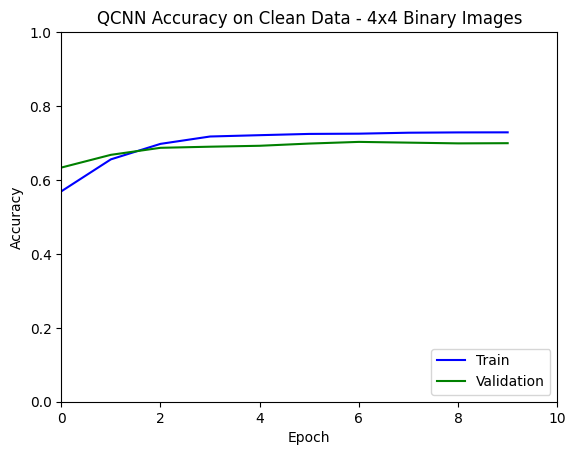

In [ ]:
# تابعی برای رسم معیارها
def plot_metrics(history, metric_name, title, ylim=1, xlim=10):
    plt.title(title)  # تنظیم عنوان نمودار
    plt.ylim(0, ylim)  # تنظیم محدوده محور y
    plt.xlim(0, xlim)  # تنظیم محدوده محور x
    plt.plot(history.history[metric_name], color='blue', label='Train')  # رسم دقت آموزش
    plt.plot(history.history['val_' + metric_name], color='green', label='Validation')  # رسم دقت اعتبارسنجی
    plt.legend(loc='lower right')  # قرار دادن لژیند در گوشه پایین راست
    plt.xlabel("Epoch")  # برچسب محور x
    plt.ylabel("Accuracy")  # برچسب محور y

# فراخوانی تابع برای رسم دقت مدل پاک
plot_metrics(history_clean, 'binary_accuracy', 'QCNN Accuracy on Clean Data - 4x4 Binary Images')

In [ ]:
# ساخت مدل نویز
noisy_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),  # ورودی داده‌ها به عنوان یک رشته tf.string
    # لایه PQC انتظار مقدار گیت خواندن را باز می‌گرداند، در بازه [-1, 1].
    tfq.layers.PQC(model_circuit, model_readout),
])

# کامپایل مدل نویزی
noisy_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # تعیین تابع ضرر به عنوان تقاطع باینری
    optimizer=tf.keras.optimizers.Adam(),                        # استفاده از بهینه‌ساز آدام
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)]    # تعیین معیار دقت باینری با آستانه 0.0
)

print(noisy_model.summary())  # چاپ خلاصه مدل شامل تعداد لایه‌ها و پارامترها

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 64        
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# آموزش مدل نویزی با داده‌های نویزی
history_noisy = noisy_model.fit(
    x_train_tfcirc_noisy, train_labels,  # داده‌های آموزشی و برچسب‌ها
    batch_size=128,                       # اندازه دسته برای آموزش
    epochs=10,                            # تعداد دوره‌های آموزش
    verbose=1,                            # نمایش پیشرفت در حین آموزش
    validation_data=(x_test_tfcirc_noisy, test_labels)  # داده‌های اعتبارسنجی
)

# ارزیابی مدل روی داده‌های آزمایشی
test_loss_noisy, test_acc_noisy = noisy_model.evaluate(x_test_tfcirc_noisy, test_labels, verbose=2)

# چاپ دقت  آزمون
print(f"Noisy Data - Test Accuracy: {test_acc_noisy:.4f}, Test Loss: {test_loss_noisy:.4f}")
print(f"Noisy Data - Training Accuracy: {history_noisy.history['binary_accuracy'][-1]:.4f}")

Epoch 1/10
94/94 [==============================] - 929s 10s/step - loss: 0.6928 - binary_accuracy: 0.5108 - val_loss: 0.6931 - val_binary_accuracy: 0.5065
Epoch 2/10
94/94 [==============================] - 923s 10s/step - loss: 0.6925 - binary_accuracy: 0.5207 - val_loss: 0.6931 - val_binary_accuracy: 0.5185
Epoch 3/10
94/94 [==============================] - 907s 10s/step - loss: 0.6920 - binary_accuracy: 0.5312 - val_loss: 0.6928 - val_binary_accuracy: 0.5120
Epoch 4/10
94/94 [==============================] - 906s 10s/step - loss: 0.6907 - binary_accuracy: 0.5371 - val_loss: 0.6906 - val_binary_accuracy: 0.5370
Epoch 5/10
94/94 [==============================] - 924s 10s/step - loss: 0.6836 - binary_accuracy: 0.5636 - val_loss: 0.6765 - val_binary_accuracy: 0.5870
Epoch 6/10
94/94 [==============================] - 917s 10s/step - loss: 0.6561 - binary_accuracy: 0.6225 - val_loss: 0.6474 - val_binary_accuracy: 0.6285
Epoch 7/10
94/94 [==============================] - 910s 10s/ste

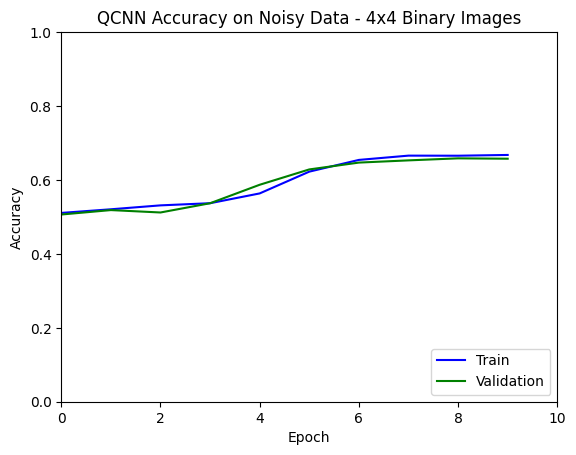

In [ ]:
plot_metrics(history_noisy, 'binary_accuracy', 'QCNN Accuracy on Noisy Data - 4x4 Binary Images')

In [ ]:
# مقایسه سایر معیارهای عملکرد
y_true = test_labels  # برچسب‌های واقعی داده‌های آزمایشی

# پیش‌بینی‌های مدل پاک
y_pred_clean_bin = clean_model.predict(x_test_tfcirc_clean)  # پیش‌بینی بر اساس مدل پاک
y_pred_clean_bin = (y_pred_clean_bin > 0.5).astype(int)  # تبدیل احتمال‌ها به کلاس‌های باینری

# پیش‌بینی‌های مدل نویزی
y_pred_noisy_bin = noisy_model.predict(x_test_tfcirc_noisy)  # پیش‌بینی بر اساس مدل نویزی
y_pred_noisy_bin = (y_pred_noisy_bin > 0.5).astype(int)  # تبدیل احتمال‌ها به کلاس‌های باینری

63/63 [==============================] - 18s 291ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # وارد کردن متریک‌های مورد نیاز

# محاسبه معیارهای مدل پاک
accuracy_clean_bin = accuracy_score(y_true, y_pred_clean_bin)  # دقت
precision_clean_bin = precision_score(y_true, y_pred_clean_bin, average='weighted')  # دقت مثبت
recall_clean_bin = recall_score(y_true, y_pred_clean_bin, average='weighted')  # یادآوری
f1_clean_bin = f1_score(y_true, y_pred_clean_bin, average='weighted')  # امتیاز F1

# چاپ معیارهای داده‌های پاک
print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean_bin:.4f}")  # چاپ دقت
print(f"Precision: {precision_clean_bin:.4f}")  # چاپ دقت مثبت
print(f"Recall: {recall_clean_bin:.4f}")  # چاپ یادآوری
print(f"F1 Score: {f1_clean_bin:.4f}")  # چاپ امتیاز F1


Clean Data Metrics:
Accuracy: 0.6565
Precision: 0.7600
Recall: 0.6565
F1 Score: 0.6185


In [ ]:
# محاسبه معیارهای مدل نویزی
accuracy_noisy_bin = accuracy_score(y_true, y_pred_noisy_bin)  # دقت
precision_noisy_bin = precision_score(y_true, y_pred_noisy_bin, average='weighted')  # دقت مثبت
recall_noisy_bin = recall_score(y_true, y_pred_noisy_bin, average='weighted')  # یادآوری
f1_noisy_bin = f1_score(y_true, y_pred_noisy_bin, average='weighted')  # امتیاز F1

# چاپ معیارهای داده‌های نویزی
print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy_bin:.4f}")  # چاپ دقت
print(f"Precision: {precision_noisy_bin:.4f}")  # چاپ دقت مثبت
print(f"Recall: {recall_noisy_bin:.4f}")  # چاپ یادآوری
print(f"F1 Score: {f1_noisy_bin:.4f}")  # چاپ امتیاز F1


Noisy Data Metrics:
Accuracy: 0.6265
Precision: 0.6425
Recall: 0.6265
F1 Score: 0.6157


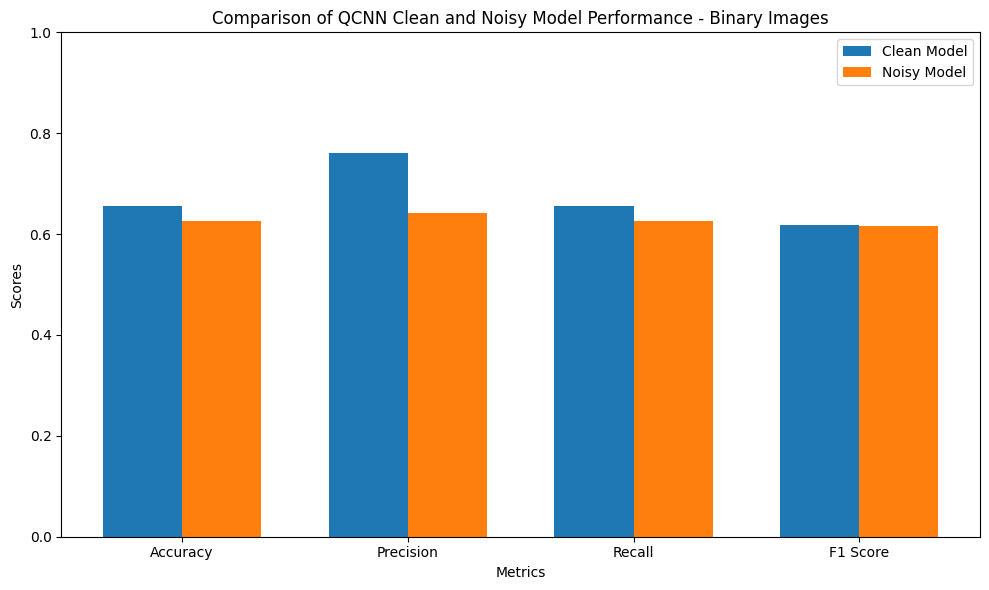

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  # اطمینان از اینکه matplotlib برای رسم نمودارها وارد شده است

# تعریف معیارها و مقادیر
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  # نام معیارها
clean_values = [accuracy_clean_bin, precision_clean_bin, recall_clean_bin, f1_clean_bin]  # مقادیر مدل پاک
noisy_values = [accuracy_noisy_bin, precision_noisy_bin, recall_noisy_bin, f1_noisy_bin]  # مقادیر مدل نویزی

# موقعیت برچسب‌ها
x = np.arange(len(metrics))  # موقعیت برچسب‌ها
width = 0.35  # عرض میله‌ها

# ایجاد نمودار
fig, ax = plt.subplots(figsize=(10, 6))  # سایز نمودار
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')  # میله‌های مدل پاک
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')  # میله‌های مدل نویزی

# تنظیمات محورهای نمودار
ax.set_xlabel('Metrics')  # برچسب محور x
ax.set_ylabel('Scores')  # برچسب محور y
ax.set_title('Comparison of QCNN Clean and Noisy Model Performance - Binary Images')  # عنوان نمودار
ax.set_xticks(x)  # تنظیمات برچسب‌های محور x
ax.set_xticklabels(metrics)  # برچسب‌های معیارها
ax.legend()  # نمایش لژیند
ax.set_ylim(0, 1)  # محدوده ثابت محور y از 0 تا 1

# تنظیمات نهایی و نمایش نمودار
plt.tight_layout()
plt.show()

In the bar plot above it is evident that this QCNN model had a higher robustness to noise compared to some classical CNNs